We're going to start by going through the Julia Images introduction:
https://juliaimages.org/latest/

Start by installing the `Images` package, plus some additional requirements.  This will take a long time!

In [268]:
] add Images TestImages ImageIO ImageMagick FileIO ImageFiltering

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [6a3955dd] + ImageFiltering v0.6.9
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [2]:
using Images
using TestImages

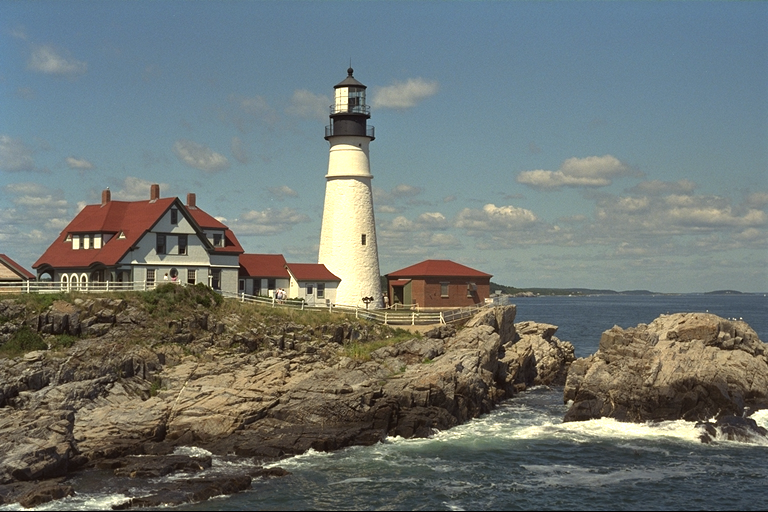

In [42]:
# Let's load one of the test images
img = testimage("lighthouse")

In [43]:
typeof(img)

Array{RGB{Normed{UInt8,8}},2}

In [44]:
size(img)

(512, 768)

Images are just arrays!  If you have a plain old 2-d array, you can display it as a black-and-white ("grayscale") image
by converting it to type `Gray`.  `Gray` images display the value `0` (or smaller) as black and `1` (or larger) as white, and values in between as shades of gray.

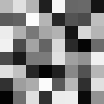

In [45]:
# If we draw random values between 0 and 1, we get "static"
r = rand(8,8)
Gray.(r)

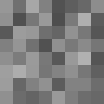

In [46]:
# If we draw random values but scale them to be between 0.3 and 0.7, they'll be more middle gray-ish
Gray.(rand(8,8) .* 0.4 .+ 0.3)

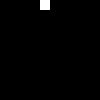

In [47]:
# Indexing rows and columns works the way you might expect:
r = zeros(10,10)
# Set one pixel to white -- row 1, column 5:
r[1, 5] = 1.
Gray.(r)

Python and other languages typically represent color ("RGB" or red-green-blue) images as 3-d arrays.

Julia treats color images as 2-d arrays of objects of type `RGB`.

In [48]:
RGB(0.0, 0.7, 0.0)

In [49]:
RGB(0.9, 0.0, 0.5)

In [10]:
x = Array(range(0., 1., length=100))
beauty = [RGB((1-xi)*0.9, xi*0.7, (1-xi)*0.5) for xi in x]

In [11]:
typeof(beauty)

Array{RGB{Float64},1}

If you have separate `red`, `green`, and `blue` arrays, you can turn them into `RGB` values using the `colorview` function:

In [12]:
# Create a (1-d) array
t = range(0, 12, length=100)
# Create (1-d) arrays for red and green -- we're going to leave blue zero here.
r = sin.(t)
g = cos.(t)
z = 0 .* t
display(colorview(RGB, r, z, z))
display(colorview(RGB, z, g, z))
display(colorview(RGB, r, g, z))

You can create a 2-d array of type `RGB`, and then set the values like this:

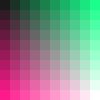

In [13]:
swatch = zeros(RGB, 10, 10)
for i = 1:10
    for j = 1:10
        swatch[i,j] = RGB(i/10, j/10, (i+j)/20)
    end
end
swatch

Just to remind ourselves that an image really is just an array of pixels, let's flip an image
different ways using array operations.

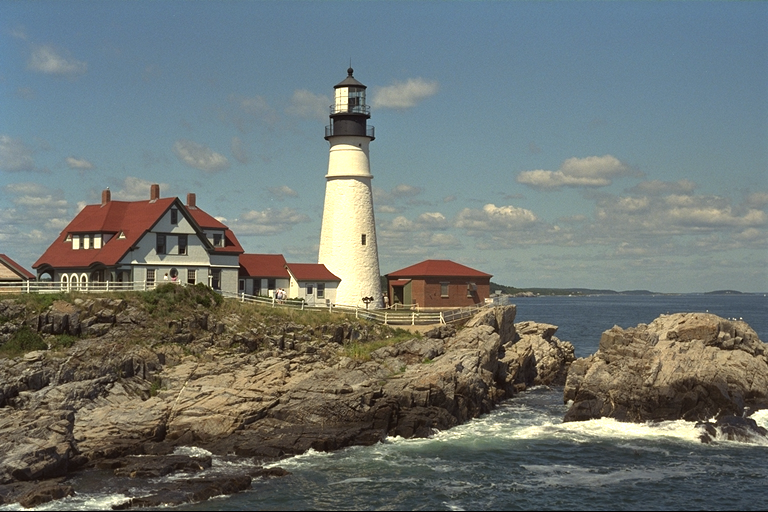

In [14]:
img

How big is the image?

In [15]:
H,W = size(img)

(512, 768)

What do you think will happen if we index the array in the reverse direction (from height `H` in steps of `-1` down to `1`, which we can write as `H:-1:1`)?

In [16]:
#img[H:-1:1,:]

What do you think the array transpose will do?

In [17]:
# transpose(img)

Let's look at the type of `img` again.

In [18]:
typeof(img)

Array{RGB{Normed{UInt8,8}},2}

Julia wants to represent images as having values between `0` and `1`, but many image formats, like JPEG,
allow only 256 levels of each of red, green, and blue, and they store them as 8-bit integers.  To make
8-bit integers and floating-point values act sort of the same, Julia has a special `Normed` type that divides by `255`.

Since this is a *physics* course, we're going to ignore all that and assume that we want to deal with plain old floating-point values.


In [57]:
rgb_array = Float32.(channelview(img))
display(typeof(rgb_array))
size(rgb_array)

Array{Float32,3}

(3, 512, 768)

From here on, let's just pull out one of the red/green/blue channels -- arbitrarily, I'm going to grab red (which I'm going to assume is in array index `1`).

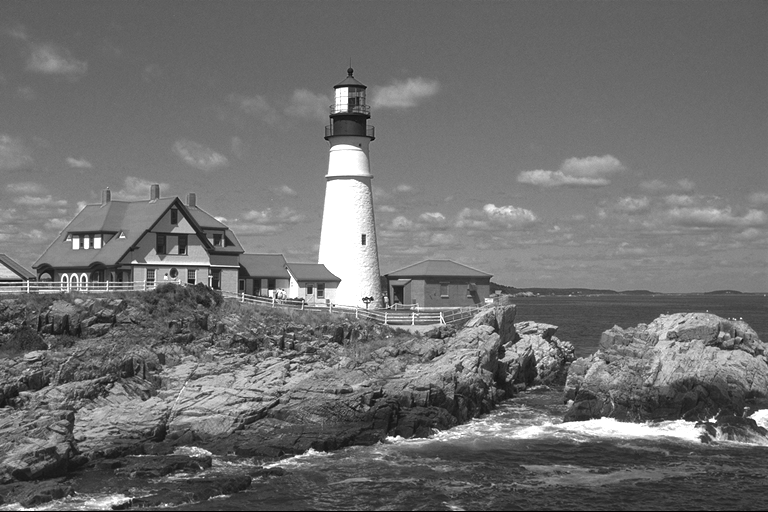

In [63]:
data = rgb_array[1,:,:]
Gray.(data)

We can modify the appearance of the image by applying operations to the pixels.  For example, what do you think will happen if we square the pixel values?  What if we take the square root?  What about stretching the value (eg, `0.5 + stretch * (data - 0.5)`)?

In [59]:
#Gray.(data.^2)

As an aside, there is a digital photo-processing transformation called "histogram equalization".  The idea is to remap the pixel values so that each pixel value appears in the image the same number of times -- if you look at the histogram of pixel values, it will be flat.

We can do this in Julia by *sorting* the pixel values and remembering which order we had to put them in so that they are sorted.  In Python this is called `argsort`.  In Julia, the `sortperm` function does this --

In [76]:
a = [1., 7., 2., 0.]
p = sortperm(a)

4-element Array{Int64,1}:
 4
 1
 3
 2

In [77]:
a[p]

4-element Array{Float64,1}:
 0.0
 1.0
 2.0
 7.0

In [83]:
# Use vec(data) to turn the 2-d array into one long vector; use sortperm() to find "inds" that sort it
inds = sortperm(vec(data))
# invert "inds" to find the rank of each pixel.
order = zeros(H*W)
order[inds] = range(0., 1., length=H*W);
#Gray.(reshape(order, (H,W)))

Since images are just 2-d arrays, we can always pull out rows or columns of the image and plot them.

Above, did you notice how part of the lighthouse stayed very white when we squared the image pixels?  What's going on there?

Let's plot a slice through the image.  The image is 512 pixels high, so let's look at pixel 200 (which, remember, counts from the top of the image).

In [84]:
using Plots

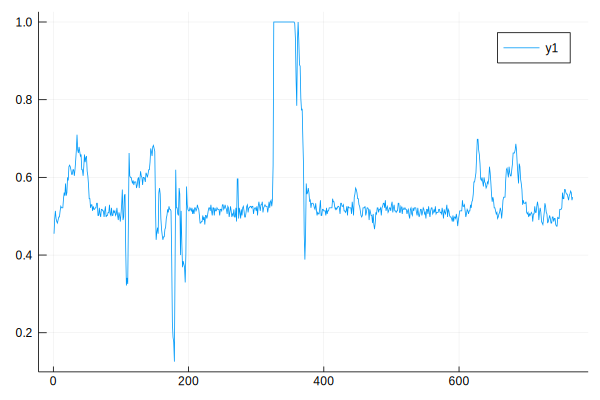

In [85]:
plot(data[200, :])

Oh look, a bunch of the pixel values are *saturated* -- they all have value `1.0` -- which happens because sensors in cameras have
a limited dynamic range.

This happens frequently in astronomical images, because CCD detectors have a maximum "well depth" or number of electrons they can hold.  We then have to treat these pixels specially.


Now, let's work on an astronomy example.  For simplicity here (to avoid building YET MORE PACKAGES),
we're going to use a JPEG image, but astronomers usually use a file format called FITS, that stores floating-point values.

(The `FITSIO` package in Julia reads FITS images.)

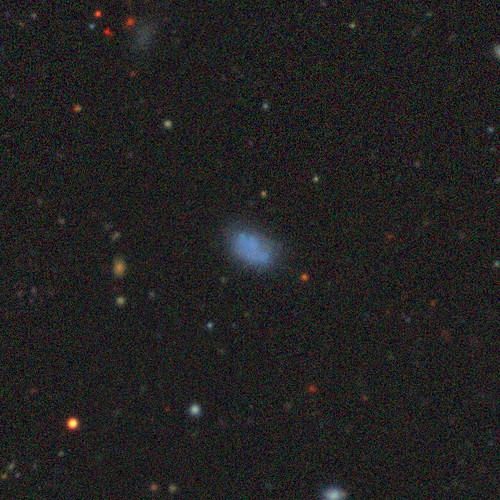

In [93]:
# The file galaxy-1.jpg here comes from
# "http://legacysurvey.org/viewer/cutout.jpg?ra=187.3902&dec=13.1956&layer=dr8&pixscale=0.262&width=500&height=500"
gimg = load("galaxy-1.jpg")

This is a small piece of sky containing some stars and galaxies, including this lumpy little blue galaxy in the center.

If you want to explore the sky, you can check out this link: http://legacysurvey.org/viewer/?ra=187.3901&dec=13.1954&layer=dr8&zoom=14

And if you want, you can find some other piece of sky you like, click on the map, and in the popup menu, follow the "Cutout" link,
and then save it as a JPEG and open it here.

Let's use the approach we used above to grab out just the blue channel of this image, and convert it to floating-point.

Note that astronomical images are basically always taken a single "band" at a time -- by placing a filter in front of the CCD.  Color images like the one above are created by taking two or more images through different filters.  Creating nice-looking color images takes some work!

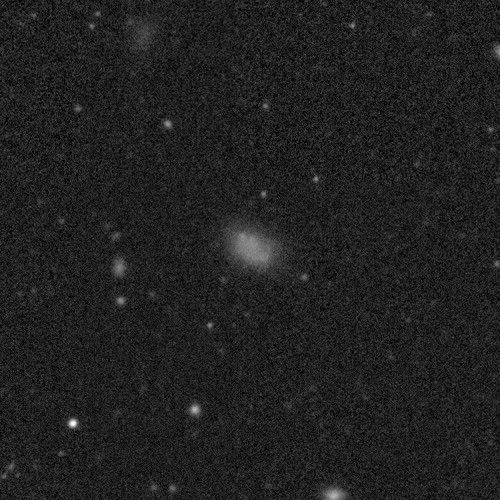

In [95]:
rgb_array = Float32.(channelview(gimg))
galaxy = rgb_array[2,:,:]
Gray.(galaxy)

And let's have a look at the image values through the center of that galaxy.

In [96]:
H,W = size(galaxy)

(500, 500)

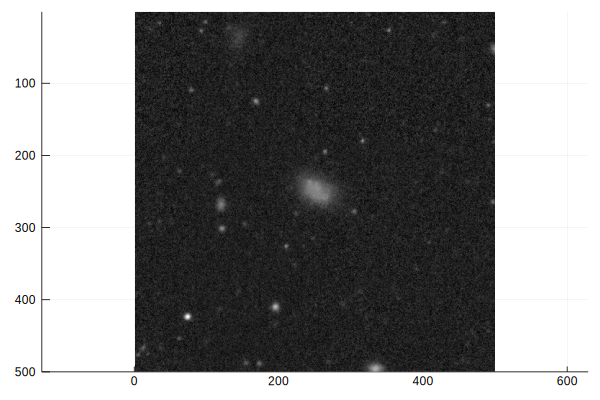

In [97]:
plot(Gray.(galaxy), aspect_ratio=1)

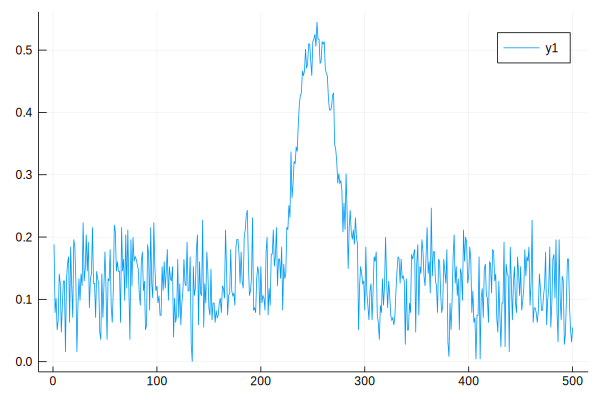

In [98]:
plot(galaxy[Int(H/2),:])

This looks like a very obvious signal (it's easy to see this galaxy by eye), yet the signal-to-noise ratio *per pixel* aren't that high.

We can increase our sensitivity -- allowing us to detect fainter galaxies -- but using a *matched filter*.

A *matched filter* works well when the data have independent, additive, zero-mean Gaussian noise with the same variance.  That's *approximately* true for this image.  To apply a *matched filter*, we correlate (or "convolve", being a little sloppy) the image with a *model* of what we expect to find.

For example, if we expect to find a Gaussian blob, we can convolve the image by a Gaussian, and places in the image that best match a Gaussian blob will respond most strongly.

Let's start by removing the bias level in this image.  If you look at the plot above, you'll see it has noise scattered around `0.1`, and we want it scattered around zero.  Let's take a very simple approach and find the `median` value in the array.

In [30]:
using Statistics

In [99]:
background = median(galaxy)

0.1254902f0

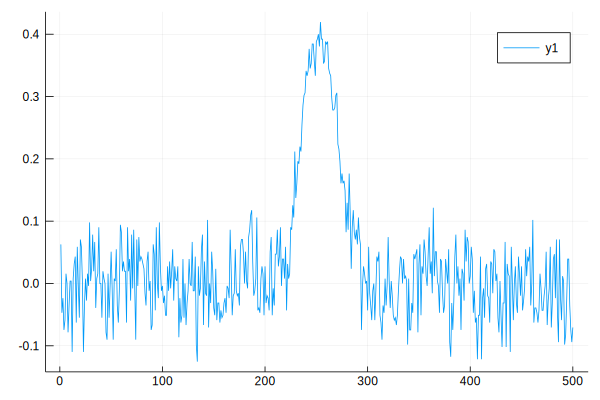

In [100]:
plot(galaxy[Int(H/2),:] .- background)

That's better!  Now, let's estimate the noise standard deviation, so we can see how much our matched filter improves
the signal-to-noise of our detection.

In [101]:
galaxy = galaxy .- background;

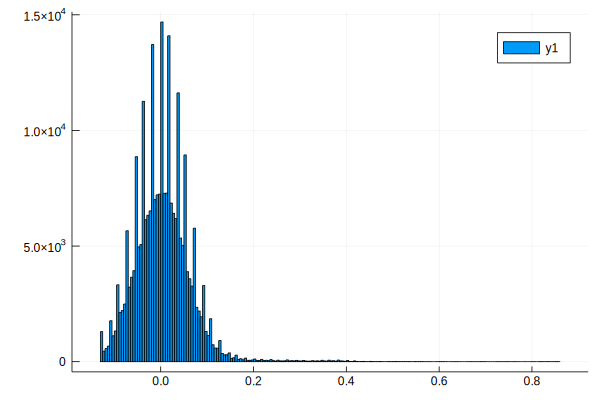

In [102]:
histogram(vec(galaxy))

See that little tail on the high side?  What do you think those bright pixels are?

Let's look at it in log space too.

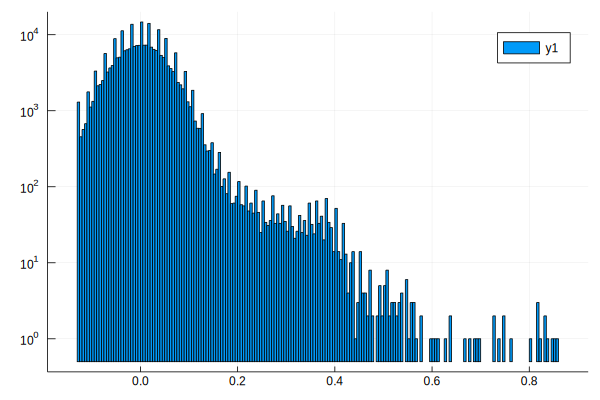

In [106]:
histogram(vec(galaxy), yscale=:log10)

Those spikes are there because we read this image as a JPEG -- remember that there are only 256 distinct values allowed -- so if the histogram binning doesn't match, you get beating.

Now, by eye, the standard deviation looks to be about `0.05`.  But there is a tail of bright pixels -- in the stars and galaxies! -- so we can't do a simple `std()` to estimate the noise.

In [103]:
std(vec(galaxy))

0.060211286f0

That's actually not too bad!  But still, let's use a slightly more robust estimate -- by looking at *quantiles*.

You might remember that 68% of the probability mass in a Gaussian is located within +- 1 sigma.  In percentiles, that means that +- 1 sigma corresponds to percentiles 50 +- 68/2, or percentiles 84 and 16.

In [107]:
lo,mid,hi = quantile(vec(galaxy), [0.16, 0.5, 0.84])

3-element Array{Float64,1}:
 -0.05098039656877518 
  0.0                 
  0.054901957511901855

So as predicted, the percentile-based noise estimate is somewhat smaller than the raw `std()` estimate, and very close to our eyeballed value of `0.05`.

Eyeballing the graph above, we see that the galaxy peak is about `0.4`, so has a signal-to-noise ratio of about `8` for the peak pixel.

Let's try convolving by Gaussians of different widths and see how that changes.

Before we do that, let's look at our plot of our one-pixel-high slice through the galaxy.

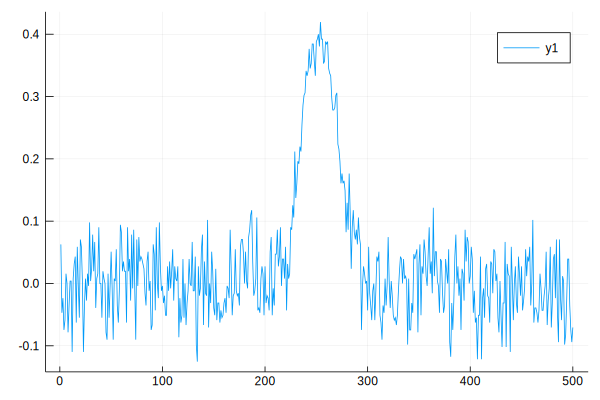

In [129]:
plot(galaxy[Int(H/2),:])

Eyeballing this plot, how wide does that galaxy peak look to you?  If we want to use a *matched filter* to detect galaxies that look like this, what Gaussian width sigma do you think will produce the largest signal-to-noise (S/N)?

Before running the Gaussian matched filter, let's build some intuition by writing our own simpler filter -- the *boxcar* or *top-hat* filter.  This is all zeros except for N pixels of ones in the center.

In [251]:
function boxcar_filter(image, boxsize)
    H,W = size(image)
    # The boxcar filter is *separable*; we'll first run over rows, then columns
    # out_rows is a temp image holding the row-filtered result.
    out_rows = zeros(Float32, (H,W))
    # "output" will be our final output (from column-filtering "out_rows")
    output = zeros(Float32, (H,W))
    halfbox = trunc(Int, boxsize/2)
    
    # for each row...
    for i = 1:H
        # for each pixel in the row...
        for j = 1:W
            # how many pixels have we summed?
            n = 0
            sum = 0.
            for offset = -halfbox:halfbox
                if (j + offset >= 1) && (j + offset <= W)
                    n += 1
                    sum += image[i, j + offset]
                end
            end
            out_rows[i, j] = sum / n
        end
    end
    # Repeat, but filtering over rows, reading from "out_rows" and writing to "output".
    for i = 1:H
        # for each pixel in the row...
        for j = 1:W
            # how many pixels have we summed?
            n = 0
            sum = 0.
            for offset = -halfbox:halfbox
                if (i + offset >= 1) && (i + offset <= H)
                    n += 1
                    sum += out_rows[i + offset, j]
                end
            end
            output[i, j] = sum / n
        end
    end
    output
end


boxcar_filter (generic function with 1 method)

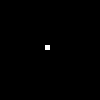

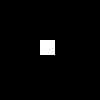

In [252]:
test = zeros(Float32, 20, 20)
test[10,10] = 1.0
display(Gray.(test))
boxtest = boxcar_filter(test, 3)
Gray.(boxtest * 9)

In [207]:
filt5 = boxcar_filter(galaxy[[Int(H/2)],:], 5)
filt25 = boxcar_filter(galaxy[[Int(H/2)],:], 25);

Before we make this plot, let's predict what we're going to see.

We're finding the *average* of a block of pixels surrounding each pixel.

What will happen if we have a constant value in the image?

What will happen if we have pure Gaussian noise?

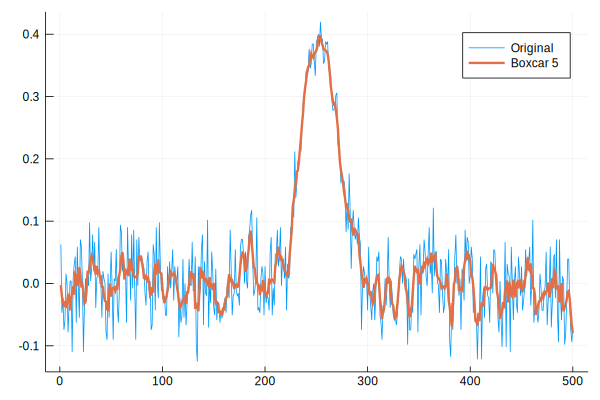

In [208]:
plot(galaxy[Int(H/2),:], label="Original")
plot!(filt5[1,:], linewidth=3, label="Boxcar 5")

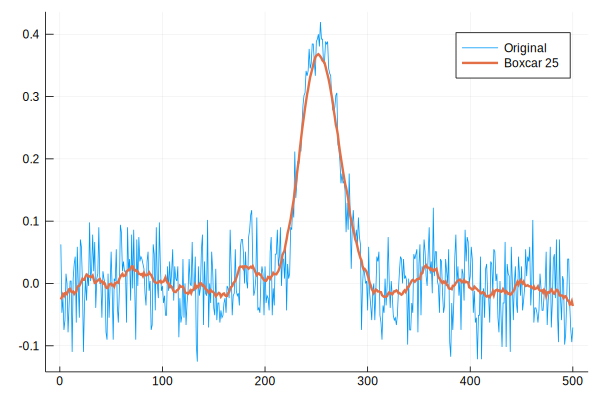

In [209]:
plot(galaxy[Int(H/2),:], label="Original")
plot!(filt25[1,:], linewidth=3, label="Boxcar 25")

Looking at the Boxcar-filtered signal, by eye, does the peak look more significant to you?  The peak is roughly the same height, but what about the noise?

Deep thought question: did we just gain a bunch of signal-to-noise for free??  What properties of the noise have changed?

Let's look at the standard deviation of the noise after boxcar filtering.

What is the standard deviation of the sum of *N* Gaussian-distributed random samples?

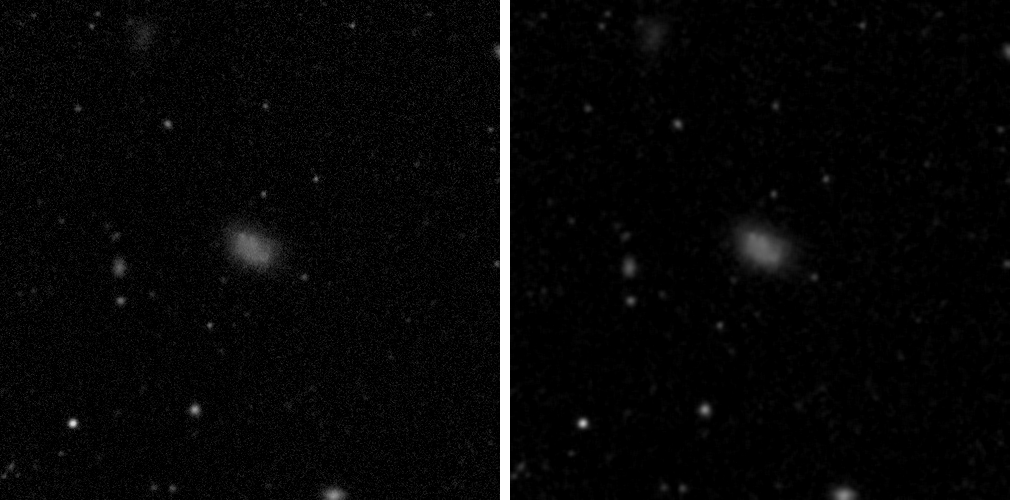

In [211]:
# Oh, first let's run the boxcar filtering on the whole galaxy image...
box5 = boxcar_filter(galaxy, 5)

Gray.(hcat(galaxy, ones(H,10), box5))

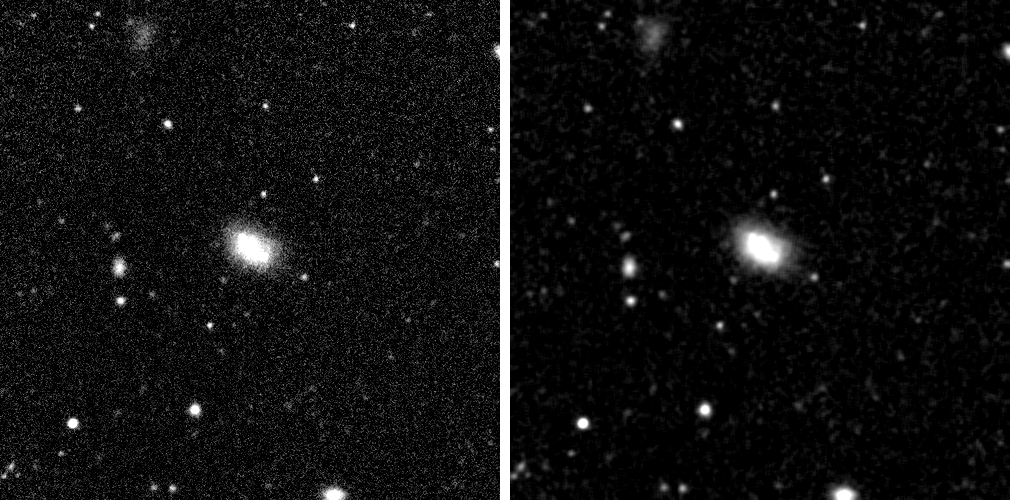

In [212]:
# Stretch it a little harder...
Gray.(hcat(3*galaxy, ones(H,10), 3*box5))

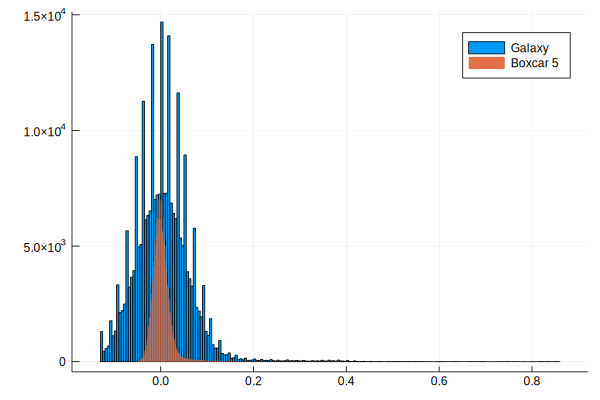

In [253]:
histogram(vec(galaxy), label="Galaxy")
histogram!(vec(box5), label="Boxcar 5", linewidth=0)

In [254]:
std(vec(galaxy)), std(vec(box5))

(0.060211286f0, 0.034839496f0)

In [255]:
# Let's use our "robust" measure -- recall that this was 0.05 for the original "galaxy" image.
lo,mid,hi = quantile(vec(box5), [0.16, 0.5, 0.84])

3-element Array{Float64,1}:
 -0.01505882479250431  
 -0.0004705902247224003
  0.01631372608244419  

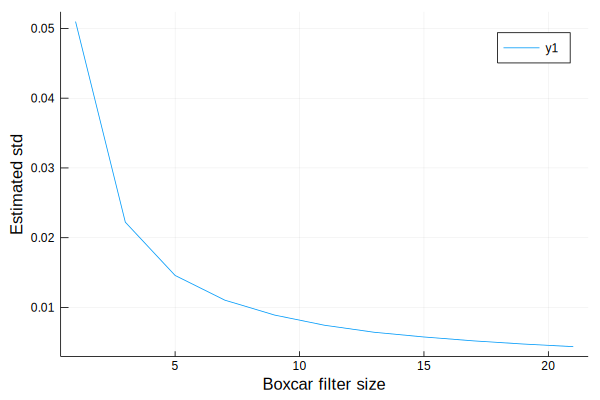

In [258]:
stds = []
boxsizes = [1, 3,5,7,9,11,13,15,17,19,21]
for boxsize in boxsizes
    box = boxcar_filter(galaxy, boxsize)
    lo,mid,hi = quantile(vec(box), [0.16, 0.5, 0.84])
    append!(stds, mid - lo)
end
plot(boxsizes, stds, xlabel="Boxcar filter size", ylabel="Estimated std")

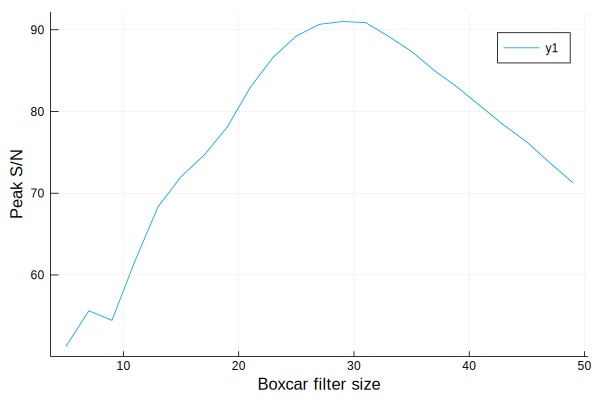

In [266]:
stds = []
peaks = []
boxsizes = 5:2:50
for boxsize in boxsizes
    box = boxcar_filter(galaxy, boxsize)
    lo,mid,hi = quantile(vec(box), [0.16, 0.5, 0.84])
    append!(stds, mid - lo)
    append!(peaks, maximum(box))
end
plot(boxsizes, peaks ./ stds, xlabel="Boxcar filter size", ylabel="Peak S/N")

Finally, let's use a Gaussian filter rather than a boxcar.  Julia has built-ins for doing this efficiently.

In [269]:
using ImageFiltering

In [ ]:
gauss5 = imfilter(galaxy, Kernel.gaussian(5));
Gray.(hcat(galaxy, ones(H,10), gauss5))